# 03: Univariate Time Series Forecast using LightGBM

### Key steps:
- [Checking the assumptions of classical time series (trend and seasonality, acf and pacf)](#is-the-series-non-stationary)
- [Demonstrating the importance of lookback window and forecast interval in the forecasting performance](#optimizing-the-lookback-window-for-the-prediction-window)
- [Comparing a Direct, Recursive and mixed step forecasting approaches](#recursive-forecasting)
- [Measuring feature importance (considering only window lags)](#feature-importance)


[1] S. Makridakis, E. Spiliotis, and V. Assimakopoulos. The M5 Accuracy competition: Results, findings and conlusions. 2020.
[2] S. Makridakis, E. Spiliotis, V. Assimakopoulos, Z. Chen, A. Gaba, I. Tsetlin, and R. Winkler. The M5 Uncertainty competition: Results, findings and conlusions. 2020.

## Fetching the data

Database connection, pivotting melted dataframe and index aggregation on "D" format.

In [1]:
from utils.database import * 
from utils.utils import *
from utils.preprocessing import *
from utils.plotting import *
from utils.metrics import *

# make training set 
train_index = 550
STEPS = 28

agg_levels = {
    'level_1': None,
}

daily_data = fetch_target()
daily_data = pivot_data(daily_data, "ettdeb")
train_agg = aggregation(daily_data, 
                        agg_levels=agg_levels).T
train_agg.plot(kind = "line")

ModuleNotFoundError: No module named 'utils'

### Preprocessing

#### Is the series non-stationary?
(it is likely stationary from ADF test)

In [2]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_agg)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.027523
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


#### Is the series seasonal?

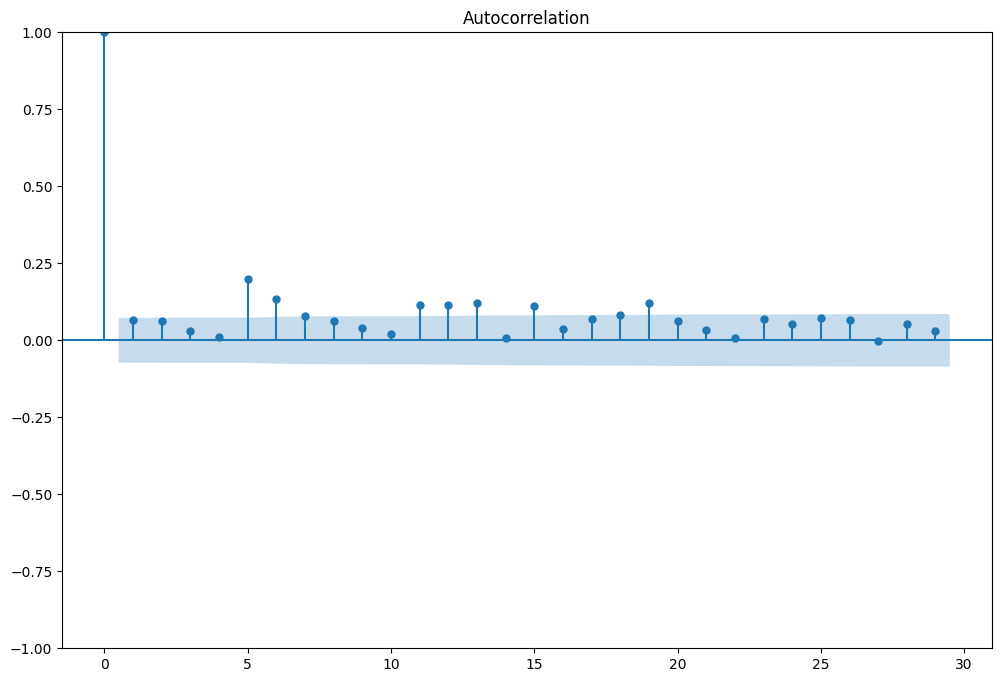

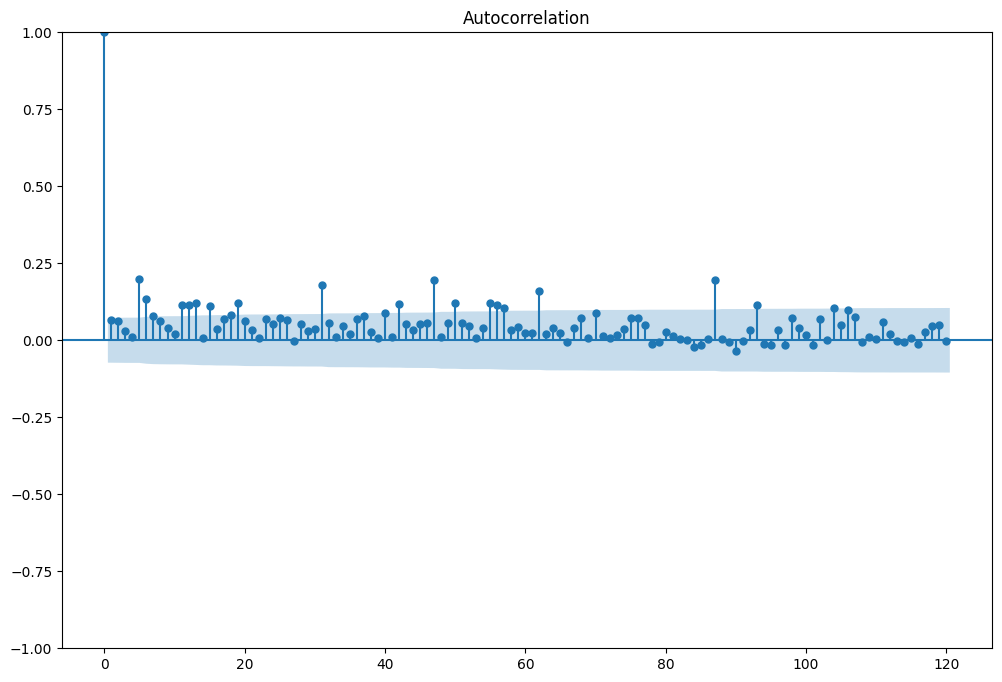

In [3]:
from statsmodels.graphics.tsaplots import plot_acf

train_agg = reconcile_date(train_agg)
plot_x_size = 12
plot_y_size = 8

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plot_acf(train_agg)
plt.show()

plot_acf(train_agg, lags = 120, use_vlines = True)
plt.show()

#### Building the test set

- series: The time series data as input.
- window_size: The size of the window used for input features (X). **LOOK BACK WINDOW**
- prediction_horizon: The number of time steps ahead to predict (the size of the output y).
- shuffle: A boolean parameter indicating whether to shuffle the created samples. By default, it's set to False.



In [4]:
### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(train_agg) - test_size
train_series = train_agg["Total"][:split_time]
test_series = train_agg["Total"][split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(333, 365)
(333,)
(28, 365)
(28,)


#### LightGBM

Gradient boosting is an ensemble method which combines multiple weak learners into strong models using the residuals from sequential models.

(518, 180) (518,)
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16185
[LightGBM] [Info] Number of data points in the train set: 518, number of used features: 180
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start t

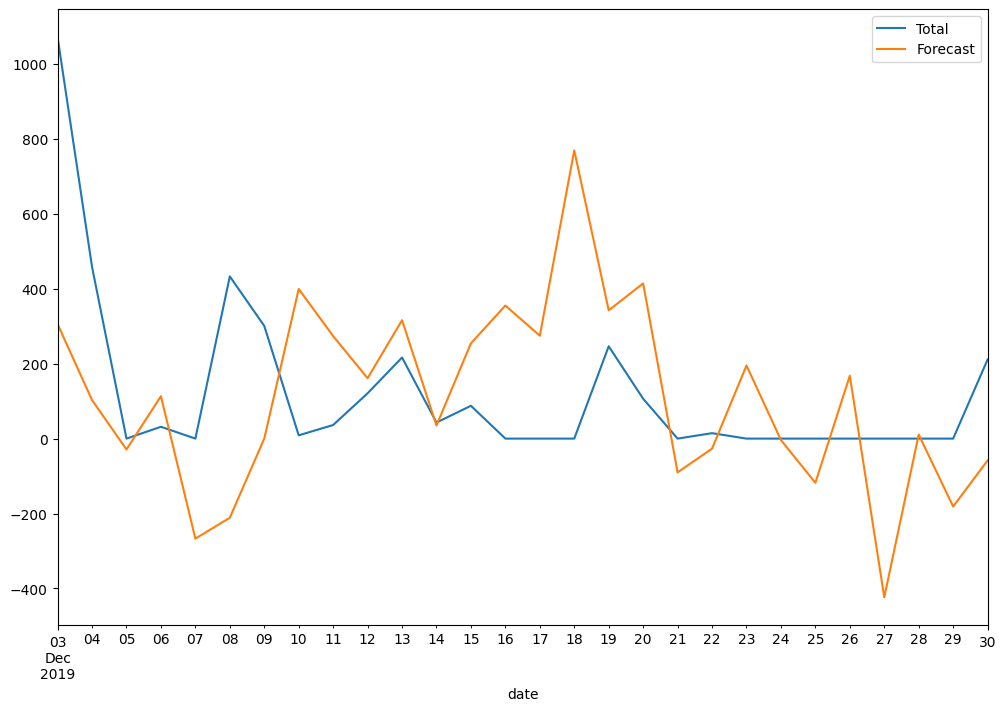

In [11]:
%%timeit

import time
import lightgbm as lgb

params = {
    'n_estimators': 500,
    'max_depth': 4,
    'num_leaves': 2**3,
    'learning_rate': 0.1,
    'boosting_type': 'goss',
    'objective': 'regression'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

print(train_x.shape, train_y.shape)
model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)])

forecast = model.predict(test_x)
s1_naive = train_agg[-29:-1].to_numpy()
s7_naive = train_agg[-35:-7].to_numpy()
s30_naive = train_agg[-56:-28].to_numpy()
s365_naive = train_agg[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

train_agg[-test_size:].plot(label = 'True')
plt.plot(test_series[-test_size:].index, forecast, label = 'Forecast')
plt.legend()
plt.show()

#### Optimizing the lookback window for the prediction window

  7 --- MAE: -601.173 (99.927)
 30 --- MAE: -531.947 (125.813)
180 --- MAE: -353.510 (51.080)
365 --- MAE: -314.662 (86.943)
545 --- MAE: -503.201 (121.960)


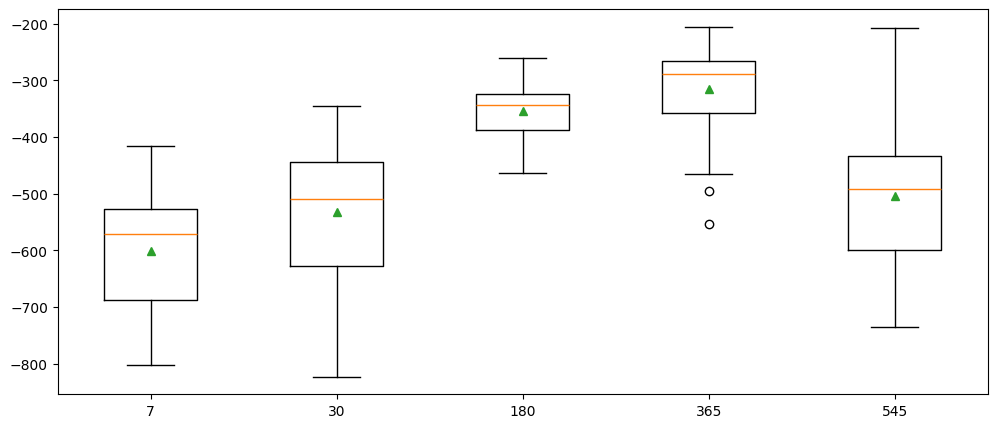

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

windows = [7, 30, 180, 365, 545]

results = []
names = []
for w in windows:

    window_size = w

    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)

    train_y = train_y.flatten()

    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [plot_x_size, 5]    
    
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### Recursive Forecasting

Generate a recursive forecasting, predicting each value at each step.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16185
[LightGBM] [Info] Number of data points in the train set: 518, number of used features: 180
[LightGBM] [Info] Start training from score 256.051661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

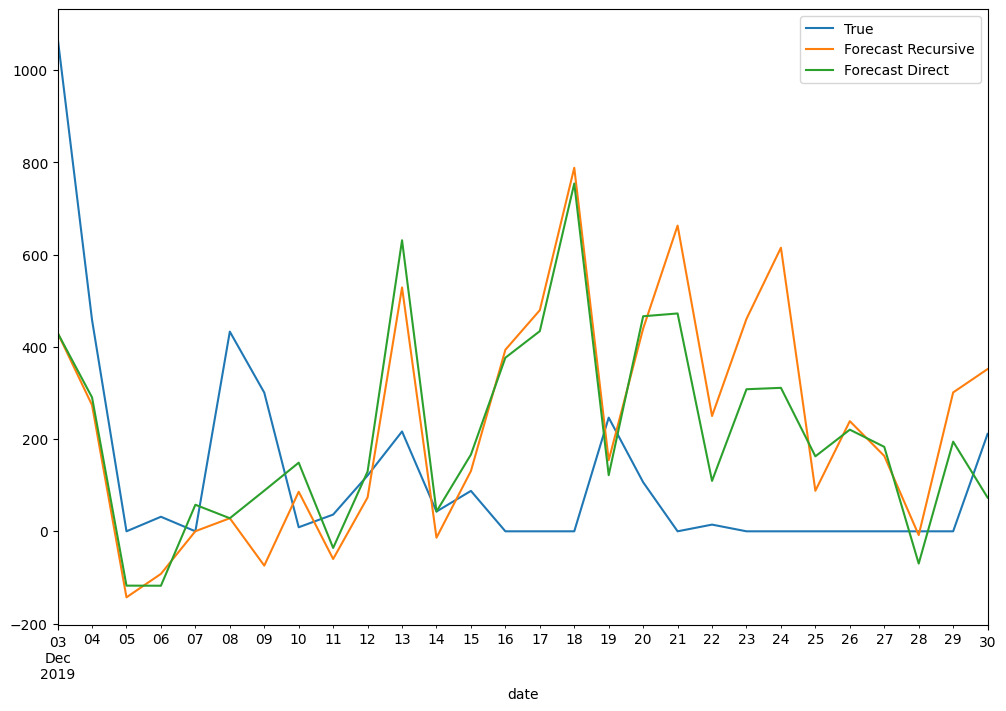

In [7]:
### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(train_agg) - test_size

train_series = train_agg["Total"][:split_time]
test_series = train_agg["Total"][split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)]
          )

recursive_x = test_x[0, :]

forecast_ms = []
for i in range(test_x.shape[0]):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model.predict(test_x)

print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

train_agg["Total"][-test_size:].plot(label = 'True')
plt.plot(train_agg["Total"][-test_size:].index, forecast_ms_rec, label = 'Forecast Recursive')
plt.plot(train_agg["Total"][-test_size:].index, forecast_os, label = 'Forecast Direct')
plt.legend()
plt.show()

#### Post processing functions

  One-Step MAE: 226.0458
Multi-Step MAE: 254.1493


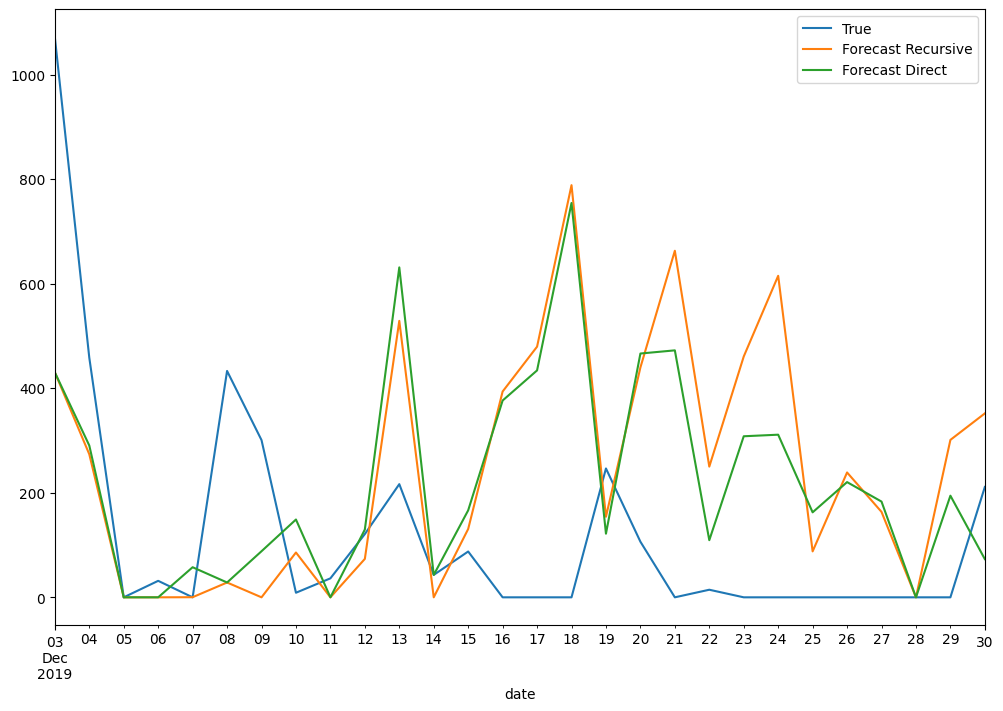

In [9]:
# RELU to prevent negative values while keeping others intact
def relu(x):
    return np.maximum(0, x)

forecast_ms_rec = relu(forecast_ms_rec)
forecast_os = relu(forecast_os)

print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

train_agg["Total"][-test_size:].plot(label = 'True')
plt.plot(train_agg["Total"][-test_size:].index, forecast_ms_rec, label = 'Forecast Recursive')
plt.plot(train_agg["Total"][-test_size:].index, forecast_os, label = 'Forecast Direct')
plt.legend()
plt.show()

#### Feature importance


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16185
[LightGBM] [Info] Number of data points in the train set: 518, number of used features: 180
[LightGBM] [Info] Start training from score 256.051661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

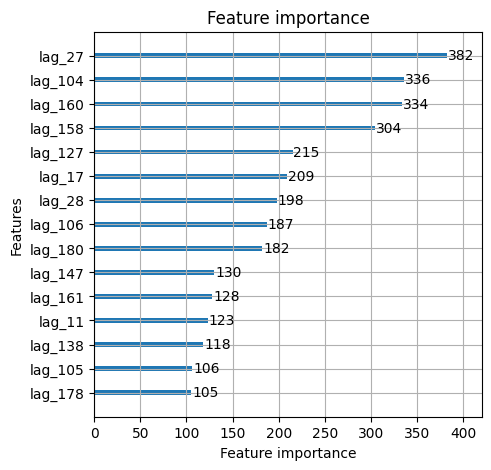

In [10]:
model = lgb.LGBMRegressor(first_metric_only = True, **params)

feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          feature_name = feature_name_list)

plt.rcParams['figure.figsize'] = [5, 5]

lgb.plot_importance(model, max_num_features = 15, importance_type = 'split')
plt.show()